# Lab 5: Spam Detection

**Deadline**: Monday, Mar 14, 5:00 PM

**Late Penalty**: Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Hossein Yousefi <hossein.yousefi@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1l9B5b2iTLxYW1q7mQ8VwMI8cQOJZq3c1/view?usp=sharing 

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [8]:
done_s = 0 
done_h = 0
for line in open('SMSSpamCollection'):
    if line[0] == 's' and done_s == 0:
      print("spam SMS:", line)
      done_s=1

    if line[0] == 'h' and done_h == 0:
      print("non-spam SMS:", line)
      done_h=1

    if done_h == 1 and done_s == 1:
      break

    

non-spam SMS: ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam SMS: spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [11]:
num_spam = 0
num_non_spam = 0

for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    num_non_spam += 1
  elif line[0] == "s":
    num_spam += 1

print("There are", num_spam, "spam SMS and", num_non_spam, "non spam SMS")

There are 747 spam SMS and 4827 non spam SMS


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:
1. There are less characters than words, so it requires less memories to store the embedding.
2. Char has length of 1 and has higher chance to be recognized while words vaires in length and sometime are misspelled.

Disadvantage:
1. The input will be a lot longer, since each word has many chars, and requires more computation。
2. Considering chars instead of words may lose meaning of the sentence, since the words have relationship in the sentence while chars do not.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [19]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

#dataset[0].sms
#dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [20]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

Having a balanced traning set can reduce the posibility of the model having bias on the dataset. In this case, ham message is much more than spam message, the model can predict all the message as ham message and still achieve a very high accuracy (not meaningful), so the model does not learn the general pattern of the message. So it is very important to have a balanced training data set so that the accuracy is meaningful. 

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [21]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

`text_field.vocab.stoi` is mapping from strings to integers, while `text_field.vocab.itos` is mapping from intger to strings

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represent the char that is not recongized in the vocabulary; while `<pad>` represents the padding of the message so that the message can have the same length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [24]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [34]:
i = 0;
for batch in train_iter:
    if i > 1:
      break
    i += 1

    print(len(batch))
    print(batch.sms)
    print(batch.label)

32
(tensor([[54,  4,  7,  ...,  3, 11, 24],
        [36, 60, 18,  ...,  7,  3, 16],
        [ 2, 10,  6,  ...,  2, 45,  1],
        ...,
        [50, 21, 22,  ...,  1,  1,  1],
        [50, 21, 22,  ...,  1,  1,  1],
        [59,  4, 12,  ...,  1,  1,  1]]), tensor([201, 201, 200, 200, 198, 197, 197, 197, 197, 197, 191, 189, 188, 185,
        183, 181, 181, 181, 181, 180, 180, 179, 179, 177, 177, 177, 176, 175,
        175, 175, 175, 174]))
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0])
32
(tensor([[54,  3,  6,  ..., 43, 28, 28],
        [54,  3,  6,  ..., 43, 28, 28],
        [54,  3,  6,  ..., 43, 28, 28],
        ...,
        [41,  6, 13,  ...,  1,  1,  1],
        [51, 19, 10,  ...,  1,  1,  1],
        [33,  4,  8,  ...,  1,  1,  1]]), tensor([90, 90, 90, 90, 90, 90, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89,
        89, 89, 89, 89, 89, 89, 89, 88, 88, 88, 88, 87, 87, 87]))
tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0,

In [37]:
i = 1
for batch in train_iter:
    if i > 10:
        break
    pad = 0
    i += 1
    for sms in batch.sms[1]:
        pad += batch.sms[1][0] - sms
    print(i, "batch: max length:",int(batch.sms[1][0]), "Number of <pad> tokens =", int(pad))

2 batch: max length: 23 Number of <pad> tokens = 1
3 batch: max length: 144 Number of <pad> tokens = 17
4 batch: max length: 114 Number of <pad> tokens = 62
5 batch: max length: 43 Number of <pad> tokens = 40
6 batch: max length: 17 Number of <pad> tokens = 229
7 batch: max length: 162 Number of <pad> tokens = 31
8 batch: max length: 90 Number of <pad> tokens = 39
9 batch: max length: 26 Number of <pad> tokens = 12
10 batch: max length: 160 Number of <pad> tokens = 0
11 batch: max length: 84 Number of <pad> tokens = 59


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [38]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [51]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes=2):
      super(RNN, self).__init__()
      self.name = "rnn"
      self.emb = torch.eye(input_size)
      self.hidden_size = hidden_size
      self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
      self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
      # Look up the embedding
      x = self.emb[x]
      # Set an initial hidden state
      h0 = torch.zeros(1, x.size(0), self.hidden_size)
      # Forward propagate the RNN
      out, _ = self.rnn(x, h0)
      # Pass the output of the last time step to the classifier
      out = self.fc(out[:, -1, :])
      return out

112

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [40]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for sms, labels in data:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [56]:
def get_val_loss(model, valid_loader, criterion):
    total_loss = 0.0
    i = 0
    for sms, labels in valid_loader:
        pred = model(sms[0])
        loss = criterion(pred, labels)
        total_loss += loss.item()
        i += 1
    val_loss = float(total_loss)/(i + 1)
    return val_loss

In [61]:
def train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []

    start_time = time.time()

    for epoch in range(num_epochs):
        i = 0;
        total_loss = 0.0
        for sms, labels in train_loader:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            i += 1
        
        epochs.append(epoch)

        train_losses.append(float(total_loss)/(i+1))
        valid_losses.append(get_val_loss(model, valid_loader, criterion))
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [58]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Epoch 1; Loss 0.679415; Train Acc 0.621600; Val Acc 0.248430
Epoch 2; Loss 0.102101; Train Acc 0.816908; Val Acc 0.704933
Epoch 3; Loss 0.655361; Train Acc 0.804203; Val Acc 0.764126
Epoch 4; Loss 0.162896; Train Acc 0.900472; Val Acc 0.956054
Epoch 5; Loss 0.363450; Train Acc 0.907477; Val Acc 0.957848
Epoch 6; Loss 0.124183; Train Acc 0.922789; Val Acc 0.894170
Epoch 7; Loss 0.423679; Train Acc 0.854862; Val Acc 0.869058
Epoch 8; Loss 0.361918; Train Acc 0.931585; Val Acc 0.945291
Epoch 9; Loss 0.161076; Train Acc 0.927838; Val Acc 0.963229
Epoch 10; Loss 0.023912; Train Acc 0.949014; Val Acc 0.972197
Epoch 11; Loss 0.089143; Train Acc 0.900961; Val Acc 0.967713
Epoch 12; Loss 0.088280; Train Acc 0.937449; Val Acc 0.895067
Epoch 13; Loss 0.255761; Train Acc 0.951947; Val Acc 0.936323
Epoch 14; Loss 0.194882; Train Acc 0.946734; Val Acc 0.916592
Epoch 15; Loss 0.084356; Train Acc 0.967096; Val Acc 0.970404
Total time elapsed: 155.83 seconds


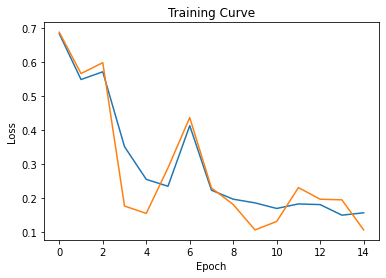

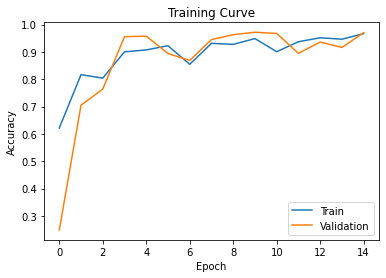

In [62]:
model = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)

train_rnn_network(model, train_iter, val_iter, num_epochs=15)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Loss 0.630494; Train Acc 0.533312; Val Acc 0.116592
Epoch 2; Loss 0.438543; Train Acc 0.843786; Val Acc 0.917489
Epoch 3; Loss 0.388265; Train Acc 0.901613; Val Acc 0.940807
Epoch 4; Loss 0.518080; Train Acc 0.916599; Val Acc 0.953363
Epoch 5; Loss 0.069178; Train Acc 0.899006; Val Acc 0.955157
Epoch 6; Loss 0.227944; Train Acc 0.904056; Val Acc 0.958744
Epoch 7; Loss 0.374379; Train Acc 0.922952; Val Acc 0.956054
Epoch 8; Loss 0.034366; Train Acc 0.940870; Val Acc 0.949776
Epoch 9; Loss 0.075865; Train Acc 0.940381; Val Acc 0.964126
Epoch 10; Loss 0.286445; Train Acc 0.936309; Val Acc 0.958744
Epoch 11; Loss 0.041061; Train Acc 0.930770; Val Acc 0.967713
Epoch 12; Loss 0.378280; Train Acc 0.946897; Val Acc 0.966816
Epoch 13; Loss 0.448252; Train Acc 0.951458; Val Acc 0.946188
Epoch 14; Loss 0.171438; Train Acc 0.953576; Val Acc 0.961435
Epoch 15; Loss 0.146387; Train Acc 0.951784; Val Acc 0.972197
Total time elapsed: 128.70 seconds


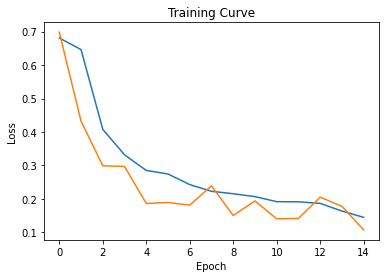

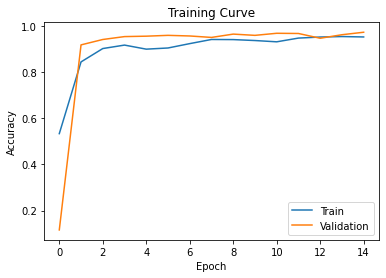

In [63]:
#case 1: since the output is a bit noisy, decrease the learning rate from 1e-4 to 1e-5
model = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)

train_rnn_network(model, train_iter, val_iter, num_epochs=15, learning_rate = 5e-5)

Epoch 1; Loss 0.724891; Train Acc 0.531846; Val Acc 0.113004
Epoch 2; Loss 0.634969; Train Acc 0.863007; Val Acc 0.868161
Epoch 3; Loss 0.579447; Train Acc 0.864799; Val Acc 0.809865
Epoch 4; Loss 0.192871; Train Acc 0.904871; Val Acc 0.943498
Epoch 5; Loss 0.201564; Train Acc 0.926372; Val Acc 0.946188
Epoch 6; Loss 0.028687; Train Acc 0.920671; Val Acc 0.886996
Epoch 7; Loss 0.583683; Train Acc 0.934680; Val Acc 0.958744
Epoch 8; Loss 0.628575; Train Acc 0.938915; Val Acc 0.937220
Epoch 9; Loss 0.222716; Train Acc 0.930119; Val Acc 0.955157
Epoch 10; Loss 0.175699; Train Acc 0.942010; Val Acc 0.960538
Epoch 11; Loss 0.029094; Train Acc 0.948037; Val Acc 0.956054
Epoch 12; Loss 0.148334; Train Acc 0.948363; Val Acc 0.936323
Epoch 13; Loss 0.120832; Train Acc 0.957322; Val Acc 0.955157
Epoch 14; Loss 0.126861; Train Acc 0.956182; Val Acc 0.957848
Epoch 15; Loss 0.253541; Train Acc 0.950481; Val Acc 0.954260
Epoch 16; Loss 0.196271; Train Acc 0.946082; Val Acc 0.973094
Epoch 17; Loss 0.

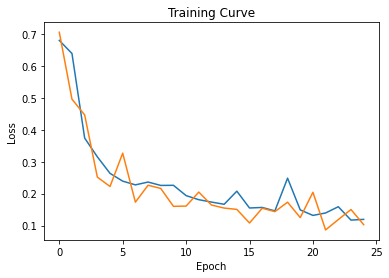

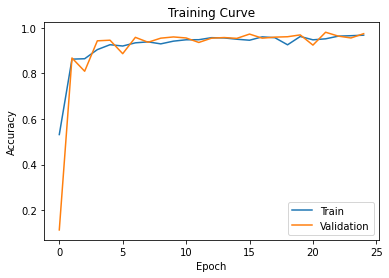

In [64]:
#case 2: since the validation loss is still decreasing, increase the number of epoches from 15 to 25
model = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)

train_rnn_network(model, train_iter, val_iter, num_epochs=25, learning_rate = 5e-5)

Epoch 1; Loss 0.694713; Train Acc 0.677146; Val Acc 0.396413
Epoch 2; Loss 0.658773; Train Acc 0.633002; Val Acc 0.304036
Epoch 3; Loss 0.767078; Train Acc 0.564098; Val Acc 0.175785
Epoch 4; Loss 0.297948; Train Acc 0.929467; Val Acc 0.911211
Epoch 5; Loss 0.312332; Train Acc 0.904545; Val Acc 0.963229
Epoch 6; Loss 0.385921; Train Acc 0.945268; Val Acc 0.950673
Epoch 7; Loss 0.148126; Train Acc 0.945268; Val Acc 0.958744
Epoch 8; Loss 0.247101; Train Acc 0.940381; Val Acc 0.955157
Epoch 9; Loss 0.165443; Train Acc 0.946734; Val Acc 0.956054
Epoch 10; Loss 0.297542; Train Acc 0.953738; Val Acc 0.944395
Epoch 11; Loss 0.117436; Train Acc 0.947711; Val Acc 0.966816
Epoch 12; Loss 0.082518; Train Acc 0.955042; Val Acc 0.954260
Epoch 13; Loss 0.115673; Train Acc 0.957159; Val Acc 0.950673
Epoch 14; Loss 0.415718; Train Acc 0.954879; Val Acc 0.967713
Epoch 15; Loss 0.060198; Train Acc 0.961231; Val Acc 0.958744
Epoch 16; Loss 0.053326; Train Acc 0.961557; Val Acc 0.953363
Epoch 17; Loss 0.

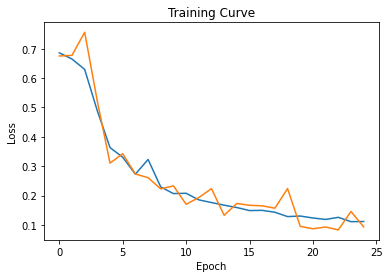

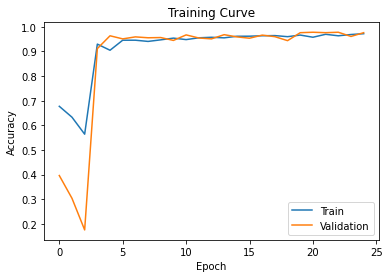

In [66]:
#case 3: change model architecture
#max-pool over the entire output array
class RNN_2(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes=2):
      super(RNN_2, self).__init__()
      self.name = "rnn"
      self.emb = torch.eye(input_size)
      self.hidden_size = hidden_size
      self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
      self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
      # Look up the embedding
      x = self.emb[x]
      # Set an initial hidden state
      h0 = torch.zeros(1, x.size(0), self.hidden_size)
      # Forward propagate the RNN
      out, _ = self.rnn(x, h0)
      # Pass the output of the last time step to the classifier
      out = self.fc(torch.max(out, dim=1)[0])
      return out

model_2 = RNN_2(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)

train_rnn_network(model_2, train_iter, val_iter, num_epochs=25, learning_rate = 5e-5)

Epoch 1; Loss 0.702999; Train Acc 0.567682; Val Acc 0.184753
Epoch 2; Loss 0.639399; Train Acc 0.587229; Val Acc 0.220628
Epoch 3; Loss 0.705032; Train Acc 0.579410; Val Acc 0.195516
Epoch 4; Loss 0.347727; Train Acc 0.888907; Val Acc 0.964126
Epoch 5; Loss 0.225996; Train Acc 0.942499; Val Acc 0.959641
Epoch 6; Loss 0.335055; Train Acc 0.930282; Val Acc 0.879821
Epoch 7; Loss 0.437185; Train Acc 0.924418; Val Acc 0.973094
Epoch 8; Loss 0.342947; Train Acc 0.955693; Val Acc 0.942601
Epoch 9; Loss 0.311540; Train Acc 0.949503; Val Acc 0.971300
Epoch 10; Loss 0.183626; Train Acc 0.943965; Val Acc 0.973094
Epoch 11; Loss 0.080271; Train Acc 0.951458; Val Acc 0.973094
Epoch 12; Loss 0.094848; Train Acc 0.959765; Val Acc 0.969507
Epoch 13; Loss 0.147647; Train Acc 0.961394; Val Acc 0.965022
Epoch 14; Loss 0.058936; Train Acc 0.958462; Val Acc 0.944395
Epoch 15; Loss 0.144854; Train Acc 0.964978; Val Acc 0.973094
Epoch 16; Loss 0.103372; Train Acc 0.966281; Val Acc 0.973094
Epoch 17; Loss 0.

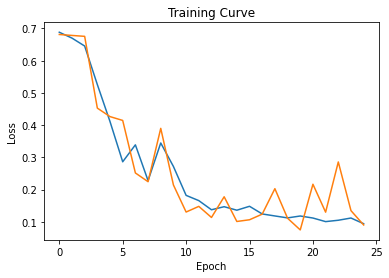

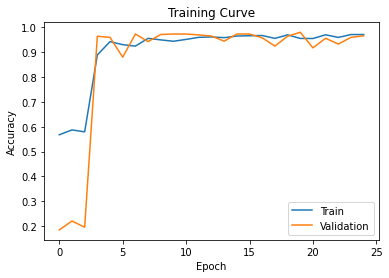

In [71]:
#case 4: change the model architecture
#concatenate the max-pooling and average-pooling of the RNN outputs
class RNN_3(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes=2):
      super(RNN_3, self).__init__()
      self.name = "rnn"
      self.emb = torch.eye(input_size)
      self.hidden_size = hidden_size
      self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
      self.fc = nn.Linear(hidden_size*2, num_classes)

  def forward(self, x):
      # Look up the embedding
      x = self.emb[x]
      # Set an initial hidden state
      h0 = torch.zeros(1, x.size(0), self.hidden_size)
      # Forward propagate the RNN
      out, _ = self.rnn(x, h0)
      # Pass the output of the last time step to the classifier
      out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
      out = self.fc(out)
      return out

model_3 = RNN_3(len(text_field.vocab.itos), len(text_field.vocab.itos), 2)

train_rnn_network(model_3, train_iter, val_iter, num_epochs=25, learning_rate = 5e-5)

The best model is model_2, and the validation accuracy is 97.57%.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [68]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [69]:
valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,      
                                           repeat=False)

valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,      
                                           repeat=False)

In [73]:
valid_false_positive = 1 - get_accuracy(model_2, valid_nospam_iter)
valid_false_negative = 1 - get_accuracy(model_2, valid_spam_iter)

print("The false positive rate is", valid_false_positive*100, "%")
print("The false negative rate is", valid_false_negative*100, "%")

The false positive rate is 2.219979818365292 %
The false negative rate is 2.4193548387096753 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

The impact of a false positive on the phone's user is that when a ham email is send to you, the algorithm have a chance to treat it as a spam. It will casues people missing very important emails!

The impact of a flase negative email is that a spam eamil is treated as ham email and you will see it in your email folder, this does not cause a huge problem compare to the flase positive situation.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [75]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,    
                                           repeat=False)

print("The final test accuracy is:",get_accuracy(model_2, test_iter)*100, "%")

The final test accuracy is: 97.30700179533214 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [76]:
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,      
                                           repeat=False)

test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,      
                                           repeat=False)    

test_false_positive = 1 - get_accuracy(model_2, test_nospam_iter)
test_false_negative = 1 - get_accuracy(model_2, test_spam_iter)

print("The false positive rate is", test_false_positive*100, "%")
print("The false negative rate is", test_false_negative*100, "%")

The false positive rate is 2.5078369905956133 %
The false negative rate is 4.458598726114649 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [101]:
msg = "machine learning is sooo cool!"

msg_int = []
for i in range(len(msg)):
    msg_int.append(text_field.vocab.stoi[msg[i]])

test_msg = torch.LongTensor(msg_int).unsqueeze(0)
pred = model_2(test_msg)
prob = F.softmax(pred, dim=1)
print("The probability is", float(prob[0][1]*100), "%")

The probability is 6.505629539489746 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam is a relatively easy task compare with other image recognition tasks. We can easily achieve pretty high test accuracy. However, the most difficult part of detecting spam is to reduce the flase positive rate as it will cause sigificant problem in real application.

A simple baseline model would be finding out some spam eamils and record the commonly appeared words. Then check an incoming email based on the frequency of these common words and assign weights to it. If the weight exceeds certain threshold value then the model can mark it as a spam email.